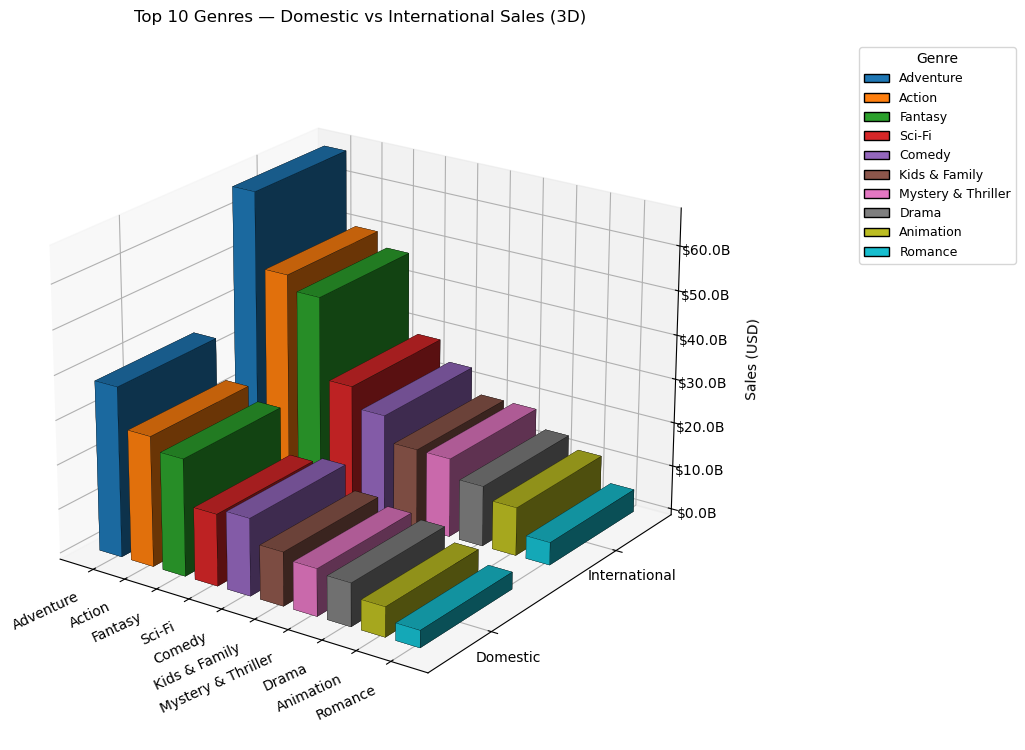

Saved: top10_genres_domestic_vs_international_color_by_genre.png


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch

# -----------------------------
# 1) Load Excel
# -----------------------------
file_path = "Movies Data.xlsx"
df = pd.read_excel(file_path)

# -----------------------------
# 2) Column detection
# -----------------------------
world_col = "World Wide Sales (in $)"

domestic_candidates = [
    "Domestic Sales (in $)", "Domestic Sales", "Domestic Gross (in $)", "Domestic Gross",
    "US Sales (in $)", "US Sales", "US Gross", "Box Office (USA)", "USA Gross"
]
dom_col = next((c for c in domestic_candidates if c in df.columns), None)

intl_candidates = [
    "International Sales (in $)", "International Sales", "International Gross (in $)",
    "International Gross", "Foreign Gross", "Non-US Sales (in $)", "Overseas Gross"
]
intl_col = next((c for c in intl_candidates if c in df.columns), None)

if world_col not in df.columns:
    raise ValueError(f"Could not find required column: '{world_col}'")
if dom_col is None and intl_col is None:
    raise ValueError(
        "Couldn't find a Domestic or International sales column.\n"
        "If your columns use different names, tell me the exact header names."
    )

# -----------------------------
# 3) Clean money columns
# -----------------------------
def clean_money(s):
    s = s.astype(str).str.replace(r"[\$,]", "", regex=True)
    return pd.to_numeric(s, errors="coerce")

keep_cols = ["Genres", world_col]
if dom_col: keep_cols.append(dom_col)
if intl_col: keep_cols.append(intl_col)

df = df[keep_cols].dropna(subset=["Genres", world_col])

df[world_col] = clean_money(df[world_col])
if dom_col: df[dom_col] = clean_money(df[dom_col])
if intl_col: df[intl_col] = clean_money(df[intl_col])

df = df.dropna(subset=[world_col])

# If International is missing, compute it
if intl_col is None and dom_col is not None:
    df["International_calc"] = df[world_col] - df[dom_col]
    intl_col = "International_calc"

# If Domestic is missing, compute it
if dom_col is None and intl_col is not None:
    df["Domestic_calc"] = df[world_col] - df[intl_col]
    dom_col = "Domestic_calc"

# Drop negatives (usually indicates bad/missing data)
df = df[(df[dom_col] >= 0) & (df[intl_col] >= 0)]

# -----------------------------
# 4) Split multi-genre cells
# -----------------------------
df["Genres"] = df["Genres"].astype(str).str.split(",")
df = df.explode("Genres")
df["Genres"] = df["Genres"].str.strip()

# -----------------------------
# 5) Pick Top 10 genres by Worldwide total
# -----------------------------
top_genres = (
    df.groupby("Genres")[world_col].sum()
      .sort_values(ascending=False)
      .head(10)
      .index
)

df_top = df[df["Genres"].isin(top_genres)].copy()

agg = (
    df_top.groupby("Genres", as_index=False)
          .agg(Domestic=(dom_col, "sum"),
               International=(intl_col, "sum"))
)
agg["Worldwide"] = agg["Domestic"] + agg["International"]
agg = agg.sort_values("Worldwide", ascending=False).head(10)

genres = agg["Genres"].tolist()
regions = ["Domestic", "International"]

# -----------------------------
# 6) Fixed colors by GENRE
# -----------------------------
palette = plt.colormaps["tab10"].colors  # 10 distinct colors
genre_colors = {g: palette[i] for i, g in enumerate(genres)}

# -----------------------------
# 7) Build 3D bars (X=Genre, Y=Region, Z=Sales)
# -----------------------------
xpos, ypos, dz, genre_labels = [], [], [], []
genre_to_x = {g: i for i, g in enumerate(genres)}
region_to_y = {r: i for i, r in enumerate(regions)}

for _, row in agg.iterrows():
    g = row["Genres"]
    for r in regions:
        xpos.append(genre_to_x[g])
        ypos.append(region_to_y[r])
        dz.append(float(row[r]))
        genre_labels.append(g)

xpos = np.array(xpos)
ypos = np.array(ypos)
zpos = np.zeros_like(xpos)

dx = np.full_like(xpos, 0.7, dtype=float)
dy = np.full_like(ypos, 0.7, dtype=float)
dz = np.array(dz, dtype=float)

bar_colors = [genre_colors[g] for g in genre_labels]

# -----------------------------
# 8) Plot + improved legend spacing
# -----------------------------
fig = plt.figure(figsize=(20, 9))
ax = fig.add_subplot(111, projection="3d")

ax.bar3d(
    xpos, ypos, zpos, dx, dy, dz,
    shade=True, color=bar_colors, edgecolor="k", linewidth=0.15
)

ax.set_title("Top 10 Genres — Domestic vs International Sales (3D)", pad=18)

# Pull Z label inward so it doesn't collide with legend
ax.set_zlabel("Sales (USD)", labelpad=12)

ax.set_xticks(np.arange(len(genres)) + 0.35)
ax.set_xticklabels(genres, rotation=25, ha="right")

ax.set_yticks(np.arange(len(regions)) + 0.35)
ax.set_yticklabels(regions)

ax.zaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"${v/1e9:.1f}B"))

ax.view_init(elev=22, azim=-55)

# MORE room on the right for both z-label and legend
plt.subplots_adjust(left=0.03, right=0.70, bottom=0.15, top=0.92)

# Genre legend outside the plot, pushed farther right + smaller font
legend_handles = [Patch(facecolor=genre_colors[g], edgecolor="k", label=g) for g in genres]
ax.legend(
    handles=legend_handles,
    title="Genre",
    loc="upper left",
    bbox_to_anchor=(1.22, 1.0),
    borderaxespad=0.0,
    fontsize=9,
    title_fontsize=10,
    frameon=True
)

# Save for Tableau
out_file = "top10_genres_domestic_vs_international_color_by_genre.png"
plt.savefig(out_file, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved: {out_file}")
